# Route calculation Monitoring/Historic data

In this notebook we will have a closer look on the various data that is generated during requests to the route-calculation service and we will try to show some possible visualizations and analysis that can be used to understand basic statistics, correlations and characteristics of parameters related to requests, responses and details behind the route-calculation service.

This reports shows, for instance how we could monitor statistic values of some parameters to judge if the algorithm is performing as expected. We also suggest a metric to be used in order to judge the quality of a route and in this way to see if changes in the algorithm/service induce an enhancement or detriment on the quality of the calculated routes.

The notebook is organized as follows, we first describe the different kinds of data available. For each set of data we illustrate some insights and try to extract some knowledge out of them in terms of statistics or figures that allow to make sense of them and or allows to monitor their time evolution.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Request-Data" data-toc-modified-id="Request-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Request Data</a></span><ul class="toc-item"><li><span><a href="#Number-of-request-per-vehicle-variant" data-toc-modified-id="Number-of-request-per-vehicle-variant-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Number of request per vehicle variant</a></span></li></ul></li><li><span><a href="#Response-Data" data-toc-modified-id="Response-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Response Data</a></span><ul class="toc-item"><li><span><a href="#Response-codes-and-error-messages" data-toc-modified-id="Response-codes-and-error-messages-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Response codes and error messages</a></span><ul class="toc-item"><li><span><a href="#Internal-errors-and-possible-Bugs" data-toc-modified-id="Internal-errors-and-possible-Bugs-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Internal errors and possible Bugs</a></span></li></ul></li><li><span><a href="#Route-Related-Data" data-toc-modified-id="Route-Related-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Route Related Data</a></span><ul class="toc-item"><li><span><a href="#Routes-in-general" data-toc-modified-id="Routes-in-general-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Routes in general</a></span></li><li><span><a href="#Vehicle-variant-specific" data-toc-modified-id="Vehicle-variant-specific-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Vehicle variant specific</a></span><ul class="toc-item"><li><span><a href="#Mean-charge-time,-recharged-battery-and-leg-distances-per-vehicle-variant-id" data-toc-modified-id="Mean-charge-time,-recharged-battery-and-leg-distances-per-vehicle-variant-id-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Mean charge time, recharged battery and leg distances per vehicle variant id</a></span></li></ul></li></ul></li><li><span><a href="#Route-Quality" data-toc-modified-id="Route-Quality-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Route Quality</a></span><ul class="toc-item"><li><span><a href="#Recharged-Battery-Energy-mode" data-toc-modified-id="Recharged-Battery-Energy-mode-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Recharged Battery Energy mode</a></span></li><li><span><a href="#Combined-quality-factor" data-toc-modified-id="Combined-quality-factor-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Combined quality factor</a></span></li><li><span><a href="#Recharged-range-rate" data-toc-modified-id="Recharged-range-rate-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Recharged range rate</a></span></li></ul></li></ul></li><li><span><a href="#Metadata" data-toc-modified-id="Metadata-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Metadata</a></span><ul class="toc-item"><li><span><a href="#Solver-metadata" data-toc-modified-id="Solver-metadata-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Solver metadata</a></span><ul class="toc-item"><li><span><a href="#Add-some-more-data" data-toc-modified-id="Add-some-more-data-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Add some more data</a></span></li></ul></li><li><span><a href="#Runtime-Meta-Data" data-toc-modified-id="Runtime-Meta-Data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Runtime Meta Data</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

## Data

The collected route-calculation data consists basically on three types. We have the request data containing the parameters and conditions with which the request was sent. Here we have information about the user, users vehicle, start and destination locations and state of charge, minimum number of charge points at station, etc.

The second type is the response data of the request. This includes the http response codes and the resulting routes, including error messages if the route was not possible to solve, or if there was any other type of error that resulted in an unsuccessful route request.

Finally, the last type of data we have is some metadata containing various runtimes of the different functions used in the route-calculation. Also information of the optimization process is collected such as number of variables, restraints, final value of the objective function, among others.

In [1]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("config", "config.py")
module = importlib.util.module_from_spec(spec)
sys.modules['config'] = module
spec.loader.exec_module(module)

from helpers import DatabaseHelper
from config import get_config
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

with DatabaseHelper.connect_mongodb() as conn:
    data = DatabaseHelper.query_history_data(conn)

2022-09-12 10:58:14,764 - MainProcess ( 1983211 ) - DEBUG - eClever Route Calculation - database - DatabaseHelper - connect_mongodb() 


In [2]:
data.head()

_id  \
0  62a0780ec4b121e115aaf860   
1  62a0781649158b7b66537e80   
2  62a07841c72d2c362edccb7c   
3  62a07849c4b121e115aaf861   
4  62a07854c4b121e115aaf862   

                                             request  \
0  {'start': [12.3772383, 51.33006], 'destination...   
1  {'start': [12.3772383, 51.33006], 'destination...   
2  {'start': [12.3772383, 51.33006], 'destination...   
3  {'start': [12.3772383, 51.33006], 'destination...   
4  {'start': [12.3772383, 51.33006], 'destination...   

                                            response  \
0  {'error': 'ROUTE_INTERNAL_ERROR', 'message': '...   
1  {'error': 'ROUTE_INTERNAL_ERROR', 'message': '...   
2  {'error': 'ROUTE_INTERNAL_ERROR', 'message': '...   
3  {'error': 'ROUTE_INTERNAL_ERROR', 'message': '...   
4  {'error': 'ROUTE_INTERNAL_ERROR', 'message': '...   

                                            metadata  
0  {'timestamp': 2022-06-08 10:21:02.046000, 'run...  
1  {'timestamp': 2022-06-08 10:21:10.056000, 'run...  
2  {'timestamp': 2022-06-08 10:21:53.174000, 'run...  
3  {'timestamp': 2022-06-08 10:22:01.841000, 'run...  
4  {'timestamp': 2022-06-08 10:22:12.202000, 'run...

In [4]:
def query_vehicle_data(pg_connection):
    """
    Query the users that are active.

    Returns:
        A pandas DataFrame with user ID, vehicle ID, vehicle type, type internal ID,
        vin and data validity range (time)
    """
    query = (
        'SELECT id, name, "nettoKwh" FROM vehiclevariants'
    )

    df = pd.read_sql_query(query, pg_connection)

    return df.set_index("id").to_dict(orient="index")

with DatabaseHelper.connect_pg_db() as conn:
    vehicle_data = query_vehicle_data(conn)

2022-09-12 10:59:03,044 - MainProcess ( 1983211 ) - DEBUG - eClever Route Calculation - database - DatabaseHelper - connect_db() db: stations


In the next step we will generate independent datasets for the request, response and metadata subsets in order to have a closer look at each subset and get some insights of the information we can learn from them.

## Request Data

Let us start with the request data. As earlier mentioned, here we have the data related to the route request and the conditions that the user has imposed for the desired route. Here we have information, for instance, about the start and destination location, the start and destination state of charge (SOC), the minimum SOC at charging stop, the amount of desired charging points at station, among others.

Below is a short sample of the first 5 entries of the data together with a table showing the available columns for this dataset.

In [473]:
request_df = pd.json_normalize(data.request)
request_df["_id"] = data["_id"]
request_df.head()

start                               destination  \
0  [12.3772383, 51.33006]  [12.378534900000002, 51.284195200000006]   
1  [12.3772383, 51.33006]                  [12.3831954, 51.2840687]   
2  [12.3772383, 51.33006]                  [12.3831954, 51.2840687]   
3  [12.3772383, 51.33006]            [12.30228, 51.342189999999995]   
4  [12.3772383, 51.33006]      [12.3364263674385, 51.3371119888071]   

   add_weight  t_in  t_out  t_in_target  t_batt  wind is_wet  \
0       100.0  20.0   20.0         20.0    20.0   0.0  False   
1       100.0  20.0   20.0         20.0    20.0   0.0  False   
2       100.0  20.0   20.0         20.0    20.0   0.0  False   
3       100.0  20.0   20.0         20.0    20.0   0.0  False   
4       100.0  20.0   20.0         20.0    20.0   0.0  False   

   vehicle_variant_id  ... soc_destination soc_min soc_max  \
0               378.0  ...            20.0    20.0   100.0   
1               378.0  ...            20.0    20.0   100.0   
2               378.0  ...            20.0    20.0   100.0   
3               378.0  ...            20.0    20.0   100.0   
4               378.0  ...            20.0    20.0   100.0   

   only_user_energy_providers             start_date_time  \
0                        True  2022-06-08T10:21:01.828566   
1                        True  2022-06-08T10:21:09.916554   
2                        True  2022-06-08T10:21:53.024799   
3                        True  2022-06-08T10:22:01.676879   
4                        True  2022-06-08T10:22:12.047862   

   destination_is_station adapter_id_ampere_list  cable_id_list  \
0                   False                    NaN            NaN   
1                   False                    NaN            NaN   
2                   False                    NaN            NaN   
3                   False                    NaN            NaN   
4                   False                    NaN            NaN   

   destination_station_id                       _id  
0                     NaN  62a0780ec4b121e115aaf860  
1                     NaN  62a0781649158b7b66537e80  
2                     NaN  62a07841c72d2c362edccb7c  
3                     NaN  62a07849c4b121e115aaf861  
4                     NaN  62a07854c4b121e115aaf862  

[5 rows x 28 columns]

In [474]:
request_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   start                         915 non-null    object 
 1   destination                   915 non-null    object 
 2   add_weight                    156 non-null    float64
 3   t_in                          796 non-null    float64
 4   t_out                         796 non-null    float64
 5   t_in_target                   796 non-null    float64
 6   t_batt                        796 non-null    float64
 7   wind                          156 non-null    float64
 8   is_wet                        156 non-null    object 
 9   vehicle_variant_id            915 non-null    float64
 10  user_id                       762 non-null    object 
 11  vehicle_id                    760 non-null    object 
 12  stations_category_list        915 non-null    object 
 13  user_

### Number of request per vehicle variant

A simple figure we can extract from these data is to check how many requests there is per vehicle variant there. One could also do it based on users instead of vehiclevariant and in this way find out from the amount of request, what is the proportion of request from on-line and off-line vehicles as shown in the donut plot below.

In [475]:
print("Number of requests per Vehicle variant Id")
vvid = pd.DataFrame(request_df.vehicle_variant_id.value_counts()) 
vvid["model"] = [vehicle_data[i]["name"] if i !=-1 else None for i in vvid.index]
vvid.rename(columns={"vehicle_variant_id":"count"})

Number of requests per Vehicle variant Id


count                           model
 402.0    355            IONIQ 5, 78 kWh, AWD
 438.0    121                      ID.3 Pro S
 391.0    109            IONIQ Elektro 31 kWh
 585.0     56            Model 3, 80 kWh, AWD
 437.0     55                        ID.3 Pro
 324.0     52                              U5
 390.0     34                         Honda e
 618.0     28           ABT e-Transporter 6.1
 353.0     23                  BMW i3 (94 Ah)
 354.0     19             i3 (94 Ah) ohne CCS
 431.0     15                 Twingo Electric
 378.0      9                          Spring
 470.0      8                        Ampera-e
-1.0        6                            None
 433.0      6     Leaf ZE1, 40 kWh, AC 6,6 kW
 398.0      4   KONA Elektro 67 kWh, AC 11 kW
 360.0      3                     i4 eDrive40
 432.0      3     Leaf ZE1, 40 kWh, AC 3,6 kW
 440.0      3       eVito Tourer PRO, 100 kWh
 393.0      2  KONA Elektro 42 kWh, AC 7,2 kW
 608.0      2        e-Golf, 24 kWh, ohne CCS
 436.0      1            ID.3 Pure, DC 100 kW
 377.0      1                Spring, ohne CCS

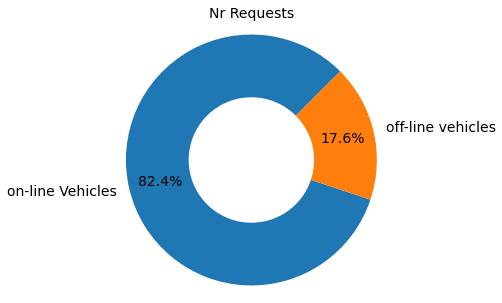

In [476]:
nr_online_vehicle_request = len(request_df.query("user_id == user_id"))
_ = [nr_online_vehicle_request, len(request_df) - nr_online_vehicle_request]
labels = ["on-line Vehicles", "off-line vehicles"]

plt.figure(figsize=(5,5))
plt.pie(_, labels=labels,
        autopct='%1.1f%%',
        pctdistance=0.75,
        startangle=45,
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
       )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Nr Requests", fontsize=14);

We can also check from the request data what the most common values for some standard parameters like the minimum SOC at charge station or the max SOC at charging. In this way we can learn what are the preferred user configurations when requesting a route. We can also somehow learn if a given parameter is actively used by users or not.

The figure below show a series of bar plots showing the amount of requests in percent with a given parameter setup.

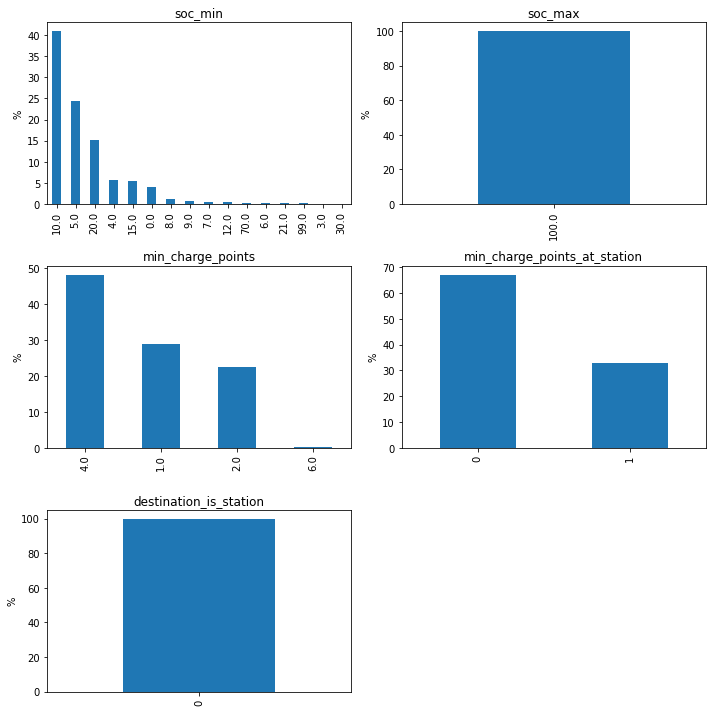

In [477]:
cols = ["soc_min", "soc_max", "min_charge_points", "min_charge_points_at_station", "destination_is_station"]

fig = plt.figure(figsize=(10,10))
for i, col in enumerate(cols):
    ax = fig.add_subplot(len(cols)//2+1, 2, i+1)
    ax.set_ylabel("%")
    if col in ["min_charge_points_at_station", "destination_is_station"]:
        x = request_df[col].dropna().astype(int).value_counts()
        x = 100*x/x.sum()
        x.plot(kind="bar", ax=ax)
    else:
        x = request_df[col].value_counts()
        x = 100*x/x.sum()
        x.plot(kind="bar", ax=ax)
    plt.title(col)
plt.tight_layout()

From the figure above we can learn, for example, that the route destination was never a charge station (bottom left fig.). This means, for instance that the app feature route to charge station has never been used so far, as all request have set this parameter to false (0 in the figure). Also we can see from figure middle right, that about {{round(100 * len(request_df.query("min_charge_points_at_station == 1"))/len(request_df))}}% of the requests have used the *min_charge_points_at_station*. This feature allows the user to decide if the amount of desired charge points at a charge station could be enclosed in a drive range of 500 meters.  

## Response Data

In this section we will have a look at the response data. Here we will have information of the results of the route request. For successful requests, the data corresponding to the route solution is given. For the case of unsuccessful request, information of the corresponding error messages is found.

### Response codes and error messages

An interesting information regarding the performance an monitoring of the route calculation will be the amount of successful vs unsuccessful requests. The table below show the number of request with given html codes. Remember that code 201 means that the request was "successful", other codes indicate an error. Code 404 is a "not found" error, whereas the 500 means that there was an "internal error".

In [478]:
response_df = pd.json_normalize(data.response)
response_df["_id"] = data["_id"]
codes_df = response_df[["_id", "error", "message", "code"]]

codes_agg =codes_df.code.value_counts()
_ = pd.DataFrame(codes_agg).rename(columns={"code":"count"})
_.index.names = ["code"]
_

count
code       
201     784
500     128
404      13

From the table above we see that {{\_.loc[201][0]}} out of {{response_df.shape[0]}} requests have been successful, the others have not. We can dig a bit deeper and see what was for instance the reason for the 500 codes by looking at the error type. 

In [479]:
code_500_agg = codes_df.query("code == 500").error.value_counts()
_ = pd.DataFrame(code_500_agg).rename(columns={"error":"count"})
_.index.names = ["error"]
_

count
error                                 
ROUTE_INTERNAL_ERROR                51
ROUTE_ERROR_BAD_PARAMETERS          41
ROUTE_ERROR_NOT_ENOUGH_STATIONS     20
ROUTE_ERROR_NO_SOLUTION             16

The table below shows that out of the {{\_.sum()[0]}} requests that have a 500 error, {{\_.loc["ROUTE_INTERNAL_ERROR"][0]}} of them have shown an internal error. This type of error means that there was an unexpected (not desired) behavior of the service. The other errors are related to the impossibility to find a solution and require active input from the user to get a better solution. For instance, change in input parameters, etc. 

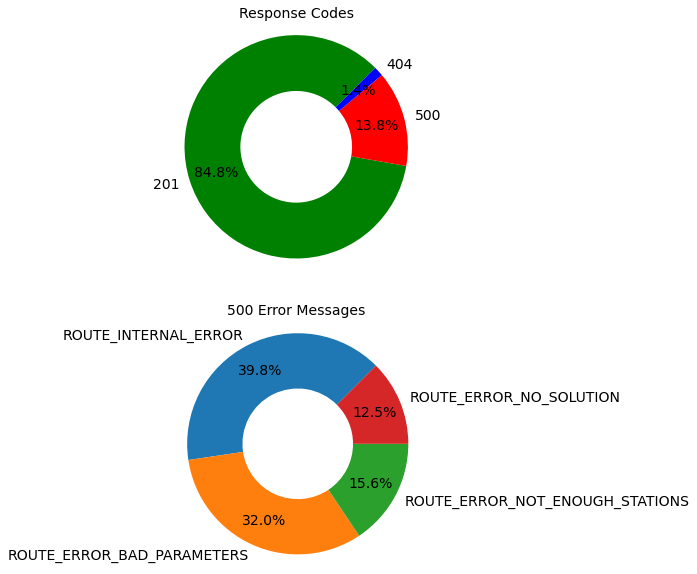

In [480]:
fig1, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].pie(codes_agg, labels=codes_agg.index.values,
        colors=["green", "red", "blue"],
        autopct='%1.1f%%',
        pctdistance=0.75,
        startangle=45,
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
       )
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title("Response Codes", fontsize=14)

ax[1].pie(code_500_agg, labels=code_500_agg.index.values,
        autopct='%1.1f%%',
        pctdistance=0.75,
        startangle=45,
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
       )
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title("500 Error Messages", fontsize=14)
plt.show()

The figure above shows a graphic representation of the tables above discussed. Here, for instance, we can see that abut {{round(100*\_.loc["ROUTE_INTERNAL_ERROR"][0]/\_.sum()[0])}}% of the requests with 500 error code are internal errors.

#### Internal errors and possible Bugs

We can go even further and get more details about the nature of these internal errors by looking at their messages. The table below shows the error messages and their count. For clarity, all errors related to the open route service have been aggregated as ORS Error. As observed, the majority of the error are due to a float division by zero. The ORS errors are mainly due to wrong locations send to the ORS API, for example by trying to calculate a route starting from the middle of a lake.

The important thing here is that by looking at this messages one can identify possible bugs that exist in the code and use this to fix them.

In [24]:
internal_error_messages = codes_df.query("error=='ROUTE_INTERNAL_ERROR'").message.values
internal_error_messages = [
    'eClever Route Calculation - Something went wrong, calculating a route!: ORS error' if re.findall("'code': 2010", mess) or  re.findall("'code': 6010", mess)
    else mess
    for mess in internal_error_messages
]

internal_error_messages = [
    'eClever Route Calculation - Something went wrong, calculating a route!: ORS error' if re.findall("'code': 4002", mess) or  re.findall("'code': 6010", mess)
    else mess
    for mess in internal_error_messages
]

internal_error_messages = [
    'eClever Route Calculation - Something went wrong, calculating a route!: SQL error' if re.findall("Execution failed on sql", mess) or  re.findall("'code': 6010", mess)
    else mess
    for mess in internal_error_messages
]


int_err_df = pd.DataFrame({"message":internal_error_messages, "count":1})

int_err_df = int_err_df.groupby("message").count().sort_values(by="count", ascending=False)
int_err_df["%"] = round(100* int_err_df["count"] / int_err_df["count"].sum(),1)
int_err_df

count     %
message                                                        
eClever Route Calculation - Something went wron...     17  33.3
eClever Route Calculation - Something went wron...     15  29.4
eClever Route Calculation - Something went wron...     10  19.6
eClever Route Calculation - Something went wron...      7  13.7
eClever Route Calculation - Something went wron...      1   2.0
eClever Route Calculation - Something went wron...      1   2.0

Regarding the 404 error codes, we see from the table below that these are due to a bad URL request.

In [25]:
codes_df.query("code==404").groupby("error").count()

_id  message  code
error                                                                 
eClever Route Calculation - 404 Not Found: The ...   13        0    13

###  Route Related Data

In this section we will have a look at the routes from successful requests, but first we will prepare the data and add some extra information related to charge stops such as amount of recharged energy, charging times and leg distances in a way that we can use for further analysis.

In [26]:
# select only successful requests
routes_response_df = response_df.query("code == 201")[["routes", "_id"]]

# routes result data
route_df = pd.DataFrame()
for r in routes_response_df.itertuples():
    for i in r.routes:
        route = pd.json_normalize(i)
        route["_id"] = r._2
        route_df = route_df.append(route)

# assign number of routes per response        
route_df["route_nr"] = route_df.groupby('_id').cumcount()

# get route length from string
route_df["routeLength"] = route_df.routeLength.apply(lambda x: float(x.split()[0].replace(",",".")))

# add info from stops
route_df["leg_distances"] = route_df.apply(lambda x: [float(stop["legDistance"].split()[0].replace(",",".")) for stop in x["stops"]] + [float(x["legDistance"].split()[0].replace(",","."))], axis=1)
route_df["charge_times"] = route_df.apply(lambda x: [stop["chargeTime"] for stop in x["stops"]], axis=1)
route_df["charge_batt"] = route_df.apply(lambda x: [stop["batteryDeparture"] - stop["batteryArrival"] for stop in x["stops"]], axis=1)

# add vehicle variant id
route_df = route_df.set_index("_id").join(request_df[["_id", "vehicle_variant_id"]].set_index("_id")).reset_index()
route_df.head()

_id  \
0  62a0841ac72d2c362edccb7f   
1  62a0842149158b7b66537e84   
2  62a084fcc4b121e115aaf865   
3  62a08505c72d2c362edccb80   
4  62a08505c72d2c362edccb80   

                                               stops  batteryArrival  \
0                                                 []              24   
1                                                 []              24   
2                                                 []              24   
3  [{'lat': 52.1740103616983, 'lng': 11.495266033...              10   
4  [{'lat': 52.2412082240361, 'lng': 10.988574604...              10   

   routeLength legDistance  legSpeed averageSpeed  chargeStops  \
0        185.9      186 km  103 km/h     103 km/h            0   
1        185.9      186 km  103 km/h     103 km/h            0   
2        185.9      186 km  103 km/h     103 km/h            0   
3        398.2      263 km  112 km/h     113 km/h            1   
4        399.5      227 km  112 km/h     112 km/h            1   

  energyConsumption   driveTime  ... stationId  \
0          59.1 kWh  1 h 48 min  ...      None   
1          59.1 kWh  1 h 48 min  ...      None   
2          59.1 kWh  1 h 48 min  ...      None   
3         100.3 kWh  3 h 30 min  ...      None   
4         100.8 kWh  3 h 33 min  ...      None   

                                  consumptionProfile  \
0  [[0.0, 90.0], [1.0, 90.0], [2.1, 89.0], [3.1, ...   
1  [[0.0, 90.0], [1.4, 90.0], [2.6, 89.0], [3.8, ...   
2  [[0.0, 90.0], [1.0, 90.0], [2.1, 89.0], [3.1, ...   
3  [[0.0, 89.0], [2.4, 88.0], [5.8, 87.0], [7.0, ...   
4  [[0.0, 81.0], [1.3, 80.0], [3.0, 79.0], [4.3, ...   

                                            polyline          routeType  \
0  [[12.360483, 51.34038], [12.360461, 51.340398]...   Schnellste Route   
1  [[12.360483, 51.34038], [12.360556, 51.34032],...   Schnellste Route   
2  [[12.360483, 51.34038], [12.360461, 51.340398]...   Schnellste Route   
3  [[12.374002, 51.332352], [12.373768, 51.332338...   Schnellste Route   
4  [[12.374002, 51.332352], [12.373768, 51.332338...  Alternative Route   

  totalCost route_nr   leg_distances charge_times charge_batt  \
0   XX.XX €        0         [186.0]           []          []   
1   XX.XX €        0         [186.0]           []          []   
2   XX.XX €        0         [186.0]           []          []   
3   XX.XX €        0  [135.0, 263.0]         [51]        [71]   
4   XX.XX €        1  [172.0, 227.0]         [48]        [71]   

   vehicle_variant_id  
0               440.0  
1               440.0  
2               440.0  
3               438.0  
4               438.0  

[5 rows x 24 columns]

In [27]:
route_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _id                 1115 non-null   object 
 1   stops               1115 non-null   object 
 2   batteryArrival      1115 non-null   int64  
 3   routeLength         1115 non-null   float64
 4   legDistance         1115 non-null   object 
 5   legSpeed            1115 non-null   object 
 6   averageSpeed        1115 non-null   object 
 7   chargeStops         1115 non-null   int64  
 8   energyConsumption   1115 non-null   object 
 9   driveTime           1115 non-null   object 
 10  chargeTime          1115 non-null   object 
 11  totalRouteTime      1115 non-null   object 
 12  timeDeparture       1115 non-null   object 
 13  timeArrival         1115 non-null   object 
 14  stationId           0 non-null      object 
 15  consumptionProfile  1115 non-null   object 
 16  polyli

#### Routes in general

There are many things we can visualize from the routes from a general perspective (taking all routes as a whole). For instance we can try to find out which is the average or most common rote lengths that the users request. We can also check which is the average time of the route it is spent charging. For this purpose it is sometimes better to aggregate the data into bins or ranges, for instance, route lengths in 50/100 km bins.

The figure below show for instance what is the amount of routes from the total that are within the given route length ranges. From the figure we see, for example, that routes are calculated mostly for routes with intermediate distances between 150 to 200 km. The next most common routes are those for typical short routes below 50 km.

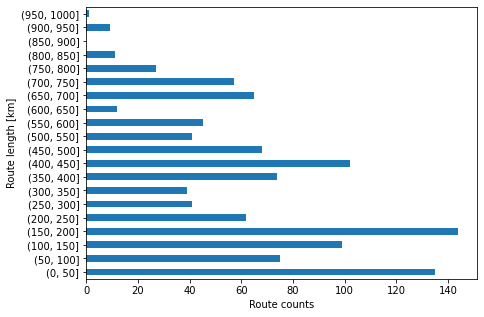

In [36]:
# aggregate route lengths into 50km bins
bins = pd.IntervalIndex.from_tuples([(50*i, (i+1)*50) for i in range(20)])
route_df["length_bin"] = pd.cut(route_df["routeLength"], bins)
plt.figure(figsize=(7,5))
route_df.groupby('length_bin').length_bin.count().plot(kind='barh')
plt.xlabel("Route counts")
plt.ylabel("Route length [km]");

We can also show some obvious relations, for example, the charge time and number of charge stops as a function of the route length. As shown below we can see that, as expected, the larger the route the longer tha charging time and the more stops we need to do.

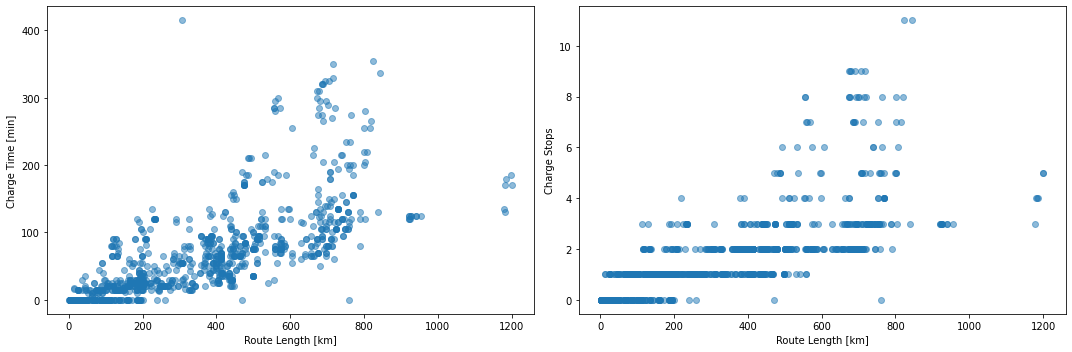

In [37]:
_ = route_df[["routeLength", "charge_times", "chargeStops"]].copy()
_["charge_times"] = _["charge_times"].apply(lambda x: np.sum(x))
_ = _.query("charge_times < 500")
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(_.routeLength,_.charge_times, 'o', alpha=0.5)
ax1.set_xlabel("Route Length [km]")
ax1.set_ylabel("Charge Time [min]")

ax2 = fig.add_subplot(1,2,2)
ax2.plot(_.routeLength,_.chargeStops, 'o', alpha=0.5)
ax2.set_xlabel("Route Length [km]")
ax2.set_ylabel("Charge Stops")

plt.tight_layout()

Regarding statistics, it is also possible to get some describing statistics. As an example, the table below shows the minimum and maximum values, mean, standard deviation and 25, 50, 75 percentiles of the charging times and recharged battery for all the routes considered. Also below is shown the corresponding histograms. 

Charge Time [min]  Recharged Battery [%]
count        1909.000000            1909.000000
mean           40.021477              56.415401
std            33.074103              24.529040
min             5.000000             -12.000000
25%            25.000000              39.000000
50%            35.000000              61.000000
75%            45.000000              76.000000
max           455.000000             100.000000

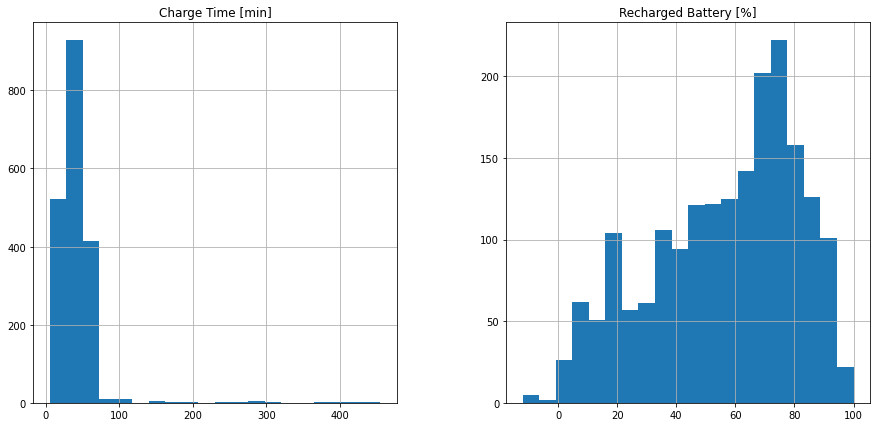

In [38]:
_ = pd.DataFrame({
    "Charge Time [min]": route_df.charge_times.sum(),
    "Recharged Battery [%]": route_df.charge_batt.sum(),
})
_.hist(figsize=(15,7), bins=20)
_.describe()

#### Vehicle variant specific

So far we have seen some data ans statistics for the whole route dataset in general. In this section we will be a bit more specific and will try to get similar insights but this time for each vehicle variant so that we can compare them. Also, it is sometimes important to get some more granularity here since many of the parameters an variables that we have analyzed so far are strongly vehicle dependent. For example, vehicles that can only charge AC, will have larger charging times as those which can charge with fast DC charger. Also, depending on the battery size, the charging times and leg distances might change.

##### Mean charge time, recharged battery and leg distances per vehicle variant id

As an example, the figure below presents the average values for charge times, recharged battery and leg distances for each vehicle variant specifically.

In [45]:
# mean chargetimes per vehicle variant
vv_times_distance_df = route_df[["vehicle_variant_id", "charge_times", "leg_distances", "charge_batt"]].groupby("vehicle_variant_id").sum()
vv_times_distance_df["mean_charge_time"] = vv_times_distance_df["charge_times"].apply(lambda x: np.mean(x))
vv_times_distance_df["mean_leg_distance"] = vv_times_distance_df["leg_distances"].apply(lambda x: np.mean(x))
vv_times_distance_df["mean_charge_batt"] = vv_times_distance_df["charge_batt"].apply(lambda x: np.mean(x))
vv_times_distance_df = vv_times_distance_df.dropna()

/home/jehamann/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


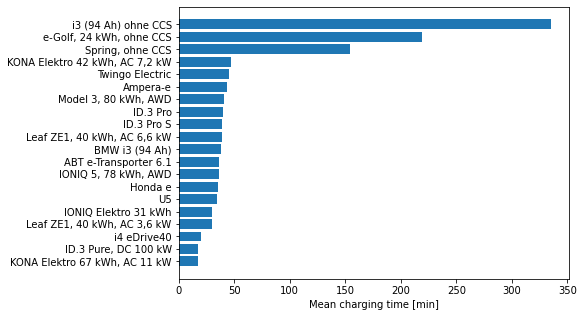

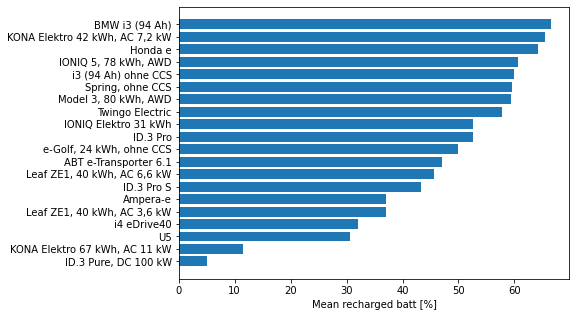

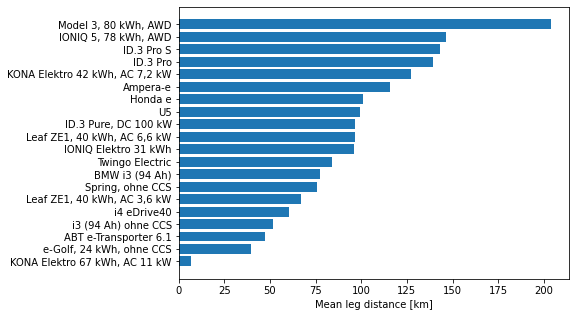

In [46]:
def plot_sorted(col, title):
    _ = vv_times_distance_df.sort_values(by=col)
    labels=[f"{vehicle_data[id]['name']}" for id in _.index]
    plt.figure(figsize=(7,5))
    plt.barh(labels, _[col])
    plt.xlabel(title);
    
plot_sorted("mean_charge_time", "Mean charging time [min]")
plot_sorted("mean_charge_batt", "Mean recharged batt [%]")
plot_sorted("mean_leg_distance", "Mean leg distance [km]")

The table below show also basic statistics for the same three parameters above shown, also vehicle variant specific.

In [47]:
def get_stats(cols):
    all_stats = pd.DataFrame()
    for id in vv_times_distance_df.index:
        
        for col in cols:
            stat = pd.Series(vv_times_distance_df.loc[id][col], name=col).describe()
            stat["name"] = vehicle_data[id]["name"]
            all_stats = all_stats.append(stat)
    return all_stats.reset_index().set_index(["name", "index"])

get_stats(["charge_times", "charge_batt", "leg_distances"])

25%    50%     75%   count  \
name                           index                                           
U5                             charge_times    20.000   30.0   45.00    78.0   
                               charge_batt     13.000   19.5   46.00    78.0   
                               leg_distances   37.000  103.0  160.00   150.0   
BMW i3 (94 Ah)                 charge_times    30.000   35.0   45.00   232.0   
                               charge_batt     57.000   70.0   80.00   232.0   
                               leg_distances   61.500   81.0   97.00   267.0   
i3 (94 Ah) ohne CCS            charge_times   280.000  340.0  420.00    14.0   
                               charge_batt     49.250   60.5   75.25    14.0   
                               leg_distances   12.950   57.0   82.00    19.0   
i4 eDrive40                    charge_times    20.000   20.0   20.00     3.0   
                               charge_batt     32.000   32.0   32.00     3.0   
                               leg_distances    4.600   60.3  116.00     6.0   
Spring, ohne CCS               charge_times   113.750  157.5  186.25     6.0   
                               charge_batt     42.750   60.5   73.00     6.0   
                               leg_distances   58.250   84.0   99.75     8.0   
Honda e                        charge_times    27.000   35.0   45.00   213.0   
                               charge_batt     46.000   68.0   81.00   213.0   
                               leg_distances   69.000  101.0  131.25   268.0   
IONIQ Elektro 31 kWh           charge_times    25.000   30.0   35.00   159.0   
                               charge_batt     43.000   61.0   74.00   159.0   
                               leg_distances   50.000   93.0  135.50   282.0   
KONA Elektro 42 kWh, AC 7,2 kW charge_times    46.000   49.5   50.00     6.0   
                               charge_batt     63.500   70.0   72.00     6.0   
                               leg_distances   97.000  135.0  152.00     9.0   
KONA Elektro 67 kWh, AC 11 kW  charge_times    16.500   17.0   17.50     2.0   
                               charge_batt     11.250   11.5   11.75     2.0   
                               leg_distances    6.000    7.0    8.00     6.0   
IONIQ 5, 78 kWh, AWD           charge_times    25.000   35.0   45.00   599.0   
                               charge_batt     45.000   66.0   78.00   599.0   
                               leg_distances   51.000  137.0  226.00  1016.0   
Twingo Electric                charge_times    30.000   47.5   60.00    66.0   
                               charge_batt     32.500   61.5   84.75    66.0   
                               leg_distances   28.000   71.0   89.00    87.0   
Leaf ZE1, 40 kWh, AC 3,6 kW    charge_times    30.000   30.0   30.00     2.0   
                               charge_batt     36.500   37.0   37.50     2.0   
                               leg_distances   40.750   63.5   89.50     4.0   
Leaf ZE1, 40 kWh, AC 6,6 kW    charge_times    30.000   40.0   47.50    23.0   
                               charge_batt     26.500   48.0   64.00    23.0   
                               leg_distances   72.000   99.0  130.50    30.0   
ID.3 Pure, DC 100 kW           charge_times    16.250   17.5   18.75     2.0   
                               charge_batt      4.500    5.0    5.50     2.0   
                               leg_distances   23.725   98.5  171.50     4.0   
ID.3 Pro                       charge_times    29.750   40.0   46.25    48.0   
                               charge_batt     35.000   51.5   66.25    48.0   
                               leg_distances   97.000  141.0  180.50   123.0   
ID.3 Pro S                     charge_times    20.000   35.0   55.00   231.0   
                               charge_batt     19.000   41.0   69.00   231.0   
                               leg_distances   53.000  130.0  220.00   400.0   
Ampera-e                       charge_times    33.

### Route Quality

One of the motivations for this project is to find a way in order to judge if the calculated routes are qualitative "good" or "bad". Hence, it will be of interest to find a way to judge this numerically. In order to do this, we need first to define when a route is considered "good". One example is, to define that a route is "good" when most of the times the battery is charged more than say 60% of its capacity. Smaller values might indicate that the route is forcing more stops than needed. Also recharged ranges above 90% indicate that the algorithm stays to long at charging stops, so making the charging time unnecessarily long.

#### Recharged Battery Energy mode
Let us explore this by plotting the statistical mode of the recharged energies per vehicle variant. Note that we will take the mode instead of the mean or median values. The reason for this, is that, assuming a normal distribution of the data, the mode is the most probable value of the distribution. The mean is very sensitive to outliers, whereas the median indicates the point at which half the values are below or above. Hence, once again, based on the available data, the mode determines the most probable value the algorithm will throw for a charge stop. Therefore, if our routes are good, as defined above, the mode of the recharged battery should be equal or larger than 60% but not larger than 90%.

To determine the mode, we will assume that the data is normally distributed (Gaussian). Then we will fit a Gaussian probability distribution function (PDF) to the data and will extract the location where the PDF is maximum (mode).

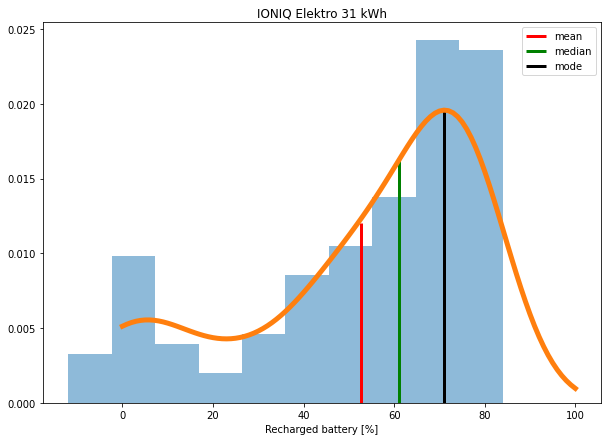

In [481]:
from scipy import stats
_ = route_df[["charge_batt", "vehicle_variant_id"]].groupby("vehicle_variant_id").sum()
_ = _.loc[391] 
plt.figure(figsize=(10,7))
dis = stats.gaussian_kde(_.charge_batt)
pdf = dis.pdf(range(101))
plt.title(f"{vehicle_data[_.name]['name']}")
plt.hist(_.charge_batt, density=True, alpha=0.5)
plt.plot(range(101), pdf, lw=5)
plt.vlines(np.array(_.charge_batt).mean(), 0, pdf[int(np.array(_.charge_batt).mean())], colors="r", label="mean", lw=3)
plt.vlines(np.median(_.charge_batt), 0, pdf[int(np.median(_.charge_batt))], colors="g", label="median", lw=3)
plt.vlines(np.argmax(pdf), 0, pdf[int(np.argmax(pdf))], label="mode", lw=3)
plt.legend()
plt.xlabel("Recharged battery [%]");

The figure above shows this procedure perform for the Ioniq Elektro (31kWh). As observed, here the mean value (red line) would be {{int(np.mean(\_.charge_batt))}} %, whereas the median (green line) is {{int(np.median(\_.charge_batt))}}%. However, the most probable value (black line) as given by the PDF is {{np.argmax(pdf)}}%. 

In terms of the route quality, the routes of the Ioniq elektro will be then considered good, since the mode, the most likely value for the recharged battery is above 60% but below 90%.

Let us not perform the same analysis for all vehicle variants and see how this parameter behaves. 

charge_batt
count    10.000000
mean     58.900000
std      24.533197
min      14.000000
25%      51.000000
50%      69.500000
75%      72.500000
max      84.000000

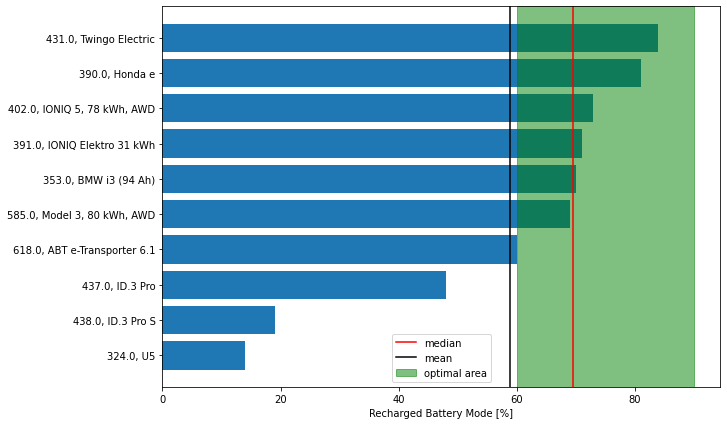

In [151]:
def get_mode(data):
    """Determines the mode from a gaussian PDF fitted on the data"""
    if len(set(data)) > 1:
        gauss_pdf = stats.gaussian_kde(data)

        return np.argmax(gauss_pdf.pdf(range(101)))
    return 

# filter vvids where nr of charges larger or equal 20 
vvids = (
    pd.DataFrame(
        route_df.query("chargeStops > 0")
        .vehicle_variant_id
        .value_counts()
    )
    .query("vehicle_variant_id >= 20")
    .index
    .values
)

_ = route_df.query("vehicle_variant_id in @vvids")
_ = _[["charge_batt", "vehicle_variant_id"]].groupby("vehicle_variant_id").sum()
_sorted = _.charge_batt.apply(lambda x: get_mode(x)).sort_values()

labels=[f"{id}, {vehicle_data[id]['name']}" for id in _sorted.index]
plt.figure(figsize=(10,7))
plt.barh(labels, _sorted)
plt.axvline(_sorted.median(), color="r", label="median")
plt.axvline(_sorted.mean(), color="k", label="mean")
plt.axvspan(60, 90, color='g', alpha=0.5, lw=1, label="optimal area")
plt.xlabel("Recharged Battery Mode [%]")
plt.legend();

pd.DataFrame(_sorted.describe())

Since we aim to do an analysis with some statistical significance, we will take for the analysis performed in this whole section only vehicles where a minimum of 20 charge stops have be recorded.

The figure above shows the mode of the recharged battery for all the vehicles that have been pre-filtered. The green area marks the region where the mode value is "good", as for our given definition of a "good" route. 

From the figure we see that most vehicles recharged battery mode is within this optimum range, only three vehicles are below. The red line shows the median of the modes for all vehicles, whereas the black line shows the mean. If we would judge the quality of all routes with a single number, we could choose between one of these, since these reflect statistically the overall behavior of the algorithm in this regard. The median values is particularly preferable since it is less influenced by outliers than the mean. In this regard, the median is a more robust indicator for the overall recharged battery mode.  

In [75]:
_ = pd.DataFrame(route_df.query("chargeStops > 0").vehicle_variant_id.value_counts())
_["model"] = [vehicle_data[i]["name"] for i in _.index]
_ = _.rename(columns={"vehicle_variant_id":"counts"})
_[["model", "counts"]]

model  counts
402.0            IONIQ 5, 78 kWh, AWD     328
438.0                      ID.3 Pro S     147
391.0            IONIQ Elektro 31 kWh      80
585.0            Model 3, 80 kWh, AWD      80
324.0                              U5      63
390.0                         Honda e      54
353.0                  BMW i3 (94 Ah)      35
437.0                        ID.3 Pro      29
618.0           ABT e-Transporter 6.1      23
431.0                 Twingo Electric      20
433.0     Leaf ZE1, 40 kWh, AC 6,6 kW       7
470.0                        Ampera-e       7
354.0             i3 (94 Ah) ohne CCS       5
393.0  KONA Elektro 42 kWh, AC 7,2 kW       3
360.0                     i4 eDrive40       3
398.0   KONA Elektro 67 kWh, AC 11 kW       2
436.0            ID.3 Pure, DC 100 kW       2
432.0     Leaf ZE1, 40 kWh, AC 3,6 kW       2
377.0                Spring, ohne CCS       2
608.0        e-Golf, 24 kWh, ohne CCS       2

#### Combined quality factor
Another way to find a parameter that reflects the quality of the route would be to combine several parameters such as the number of stops, total route length and amount of recharged battery energy. However, this parameter is more difficult to extrapolate to all vehicle variants since the amount of stops depends on the battery size of the particular vehicle. In order to make such quality parameter comparable we will need to normalize it, for instance with the battery capacity of the vehicle. 

In the figure below we have tried to get a quality parameter given by the following formula

\begin{equation*}
    Q = \dfrac{\rm{Nr. Stops} \cdot \rm{Recharged~Battery} \cdot Netto Battery}{\rm{Route~length}} [\dfrac{Stop \cdot kWh}{100~km}]
\end{equation*}

So for each route we calculate this parameter, then we aggregate them per vehicle variant and take the median value. This value is the one shown in the figure below.

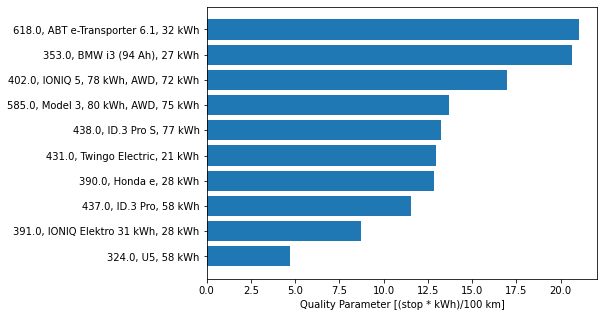

In [87]:
_ = route_df.query("vehicle_variant_id in @vvids")
_ = _[["routeLength", "vehicle_variant_id", "chargeStops", "charge_batt"]].query("chargeStops > 0 and vehicle_variant_id != 398").copy()
_["test"] = _.apply(lambda x: (x.chargeStops*vehicle_data[x.vehicle_variant_id]["nettoKwh"])*np.mean(x.charge_batt)/(x.routeLength), axis=1)
_ = _.groupby("vehicle_variant_id").median()

_sorted = _.sort_values(by="test")
labels=[f"{id}, {vehicle_data[id]['name']}, {vehicle_data[id]['nettoKwh']:.0f} kWh" for id in _sorted.index]
plt.figure(figsize=(7,5))
plt.barh(labels, _sorted.test)
plt.xlabel("Quality Parameter [(stop * kWh)/100 km]");

The problem with this parameter is that it is difficult to understand, and it is also not easy to determine what would be here a "good" or "bad" value.

#### Recharged range rate

Another final parameter we could extract from the route data would be the recharged range in km per min of charge. Although, this parameter can not be used as a quality parameter since it is actually dependent on the battery properties of each vehicle variants battery, we can still use it to compare the vehicles charging behavior, which should reflect charging curve and consumption data developed in eClever.

We do this by dividing for each route the mean of the leg distance between charge points with respect to the mean charging time. In this way, we get a sense on how many kilometers we actually recharge per charging minute.

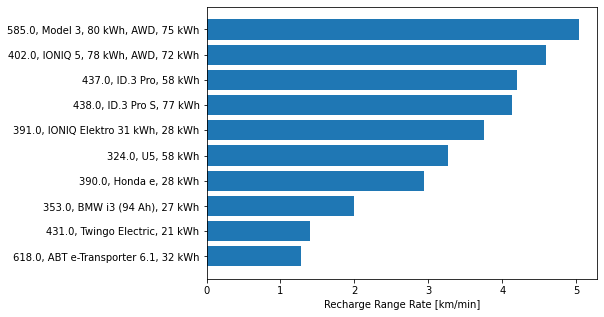

In [89]:
_ = route_df.query("vehicle_variant_id in @vvids")
_ = _[["routeLength", "vehicle_variant_id", "chargeStops", "charge_batt", "charge_times", "leg_distances"]].query("chargeStops > 0 and vehicle_variant_id != 398").copy()
_["test"] = _.apply(lambda x: (np.mean(x.leg_distances)/np.mean(x.charge_times)), axis=1)
_ = _.groupby("vehicle_variant_id").median()

_sorted = _.sort_values(by="test")
labels=[f"{id}, {vehicle_data[id]['name']}, {vehicle_data[id]['nettoKwh']:.0f} kWh" for id in _sorted.index]
plt.figure(figsize=(7,5))
plt.barh(labels, _sorted.test)
plt.xlabel("Recharge Range Rate [km/min]");

The figure above shows the mean aggregated recharged rate by vehicle variant.

From the figure we can see that the {{vehicle_data[\_sorted.index[-1]]["name"]}}
charges about {{int(\_sorted.iloc[-1]["test"])}} km per minute, whereas the Twingo Electric which can only charge AC, recharges about {{int(\_sorted.loc[431]["test"])}} km per minute.

## Metadata

The final subset of the route calculation data is the metadata. Here we have two additional subsets, one for the metadata related to parameters of the solver that is used to optimize the calculated routes. Whereas the other subset has data related to the runtimes of the various functions and steps used during the routing calculation.

### Solver metadata


We will start this section by looking at the solver metadata. Here we find information such as the final value of the objective function, the gap value, the number of constraints and variables, walltime of the optimization and the type of solution (feasible, infeasible, optimal)


In [91]:
#deserialize metadata
metadata_df = pd.json_normalize(data.metadata)
metadata_df["_id"] = data["_id"]

# routes result data
solver_df = pd.DataFrame()
for r in metadata_df.itertuples():
    for i in r.solverMetadata:
        solution = pd.json_normalize(i)
        solution["_id"] = r[-1]
        solver_df = solver_df.append(solution)

# assign number of routes per response        
solver_df["sol_nr"] = solver_df.groupby('_id').cumcount()
solver_df.head()

objective  lowerBound  gap  gapLimit  constraints  variables solutionType  \
0        0.0      273.42 -1.0       0.2         61.0       55.0   Infeasible   
0        0.0      273.42 -1.0       0.2         62.0       56.0   Infeasible   
0     -915.0     -915.00 -0.0       0.2         16.0       63.0      Optimal   
0     -732.0     -732.00 -0.0       0.2         13.0       51.0      Optimal   
0     -732.0     -732.00 -0.0       0.2         13.0       51.0      Optimal   

   walltime                       _id  sol_nr  
0      12.0  62a0799749158b7b66537e82       0  
0      12.0  62a079abc72d2c362edccb7e       0  
0       7.0  62a0841ac72d2c362edccb7f       0  
0       9.0  62a0841ac72d2c362edccb7f       1  
0       7.0  62a0842149158b7b66537e84       0

In [92]:
solver_df.describe()

objective     lowerBound          gap  gapLimit  constraints  \
count   1555.000000   1.555000e+03  1555.000000    1555.0  1555.000000   
mean      71.619916            inf     0.005685       0.2   729.444373   
std     4044.214632            inf     0.245319       0.0  1176.685630   
min   -91707.000000  -9.170700e+04    -1.000000       0.2     1.000000   
25%      -37.500000  -4.256000e+01    -0.000000       0.2    18.000000   
50%      171.070000   1.953300e+02     0.030000       0.2   266.000000   
75%      529.980000   5.253750e+02     0.100000       0.2   828.500000   
max    15726.900000  1.797693e+308     0.430000       0.2  8136.000000   

         variables      walltime       sol_nr  
count  1555.000000   1555.000000  1555.000000  
mean    656.394212    381.508682     0.436656  
std    1072.218333    820.038803     0.496131  
min       2.000000      2.000000     0.000000  
25%      51.000000      9.500000     0.000000  
50%     232.000000     94.000000     0.000000  
75%     745.000000    405.000000     1.000000  
max    7348.000000  10167.000000     1.000000

#### Add some more data

We could add some additional data in order to add more context to the solver data. For instance we can add which was the total length of the route, and try draw some conclusions about it. We could also add the vehicle variant id and do a comparison between vehicles regarding the solver behavior. Lets try for instance with the route length.

In [95]:
# add vehicle variant id
solver_df = solver_df.set_index("_id").join(request_df[["_id", "vehicle_variant_id"]].set_index("_id")).reset_index()
# add route length
solver_df = solver_df.set_index("_id").join(route_df[["_id", "routeLength"]].set_index("_id")).reset_index()

solver_df.head()

_id  objective  lowerBound  gap  gapLimit  \
0  62a0799749158b7b66537e82        0.0      273.42 -1.0       0.2   
1  62a079abc72d2c362edccb7e        0.0      273.42 -1.0       0.2   
2  62a0841ac72d2c362edccb7f     -915.0     -915.00 -0.0       0.2   
3  62a0841ac72d2c362edccb7f     -732.0     -732.00 -0.0       0.2   
4  62a0842149158b7b66537e84     -732.0     -732.00 -0.0       0.2   

   constraints  variables solutionType  walltime  sol_nr  vehicle_variant_id  \
0         61.0       55.0   Infeasible      12.0       0               378.0   
1         62.0       56.0   Infeasible      12.0       0               378.0   
2         16.0       63.0      Optimal       7.0       0               440.0   
3         13.0       51.0      Optimal       9.0       1               440.0   
4         13.0       51.0      Optimal       7.0       0               440.0   

   routeLength  
0          NaN  
1          NaN  
2        185.9  
3        185.9  
4        185.9

Correlation Matrix


constraints  variables  walltime  routeLength
constraints     1.000000   0.997027  0.618201     0.474086
variables       0.997027   1.000000  0.607563     0.454110
walltime        0.618201   0.607563  1.000000     0.422155
routeLength     0.474086   0.454110  0.422155     1.000000

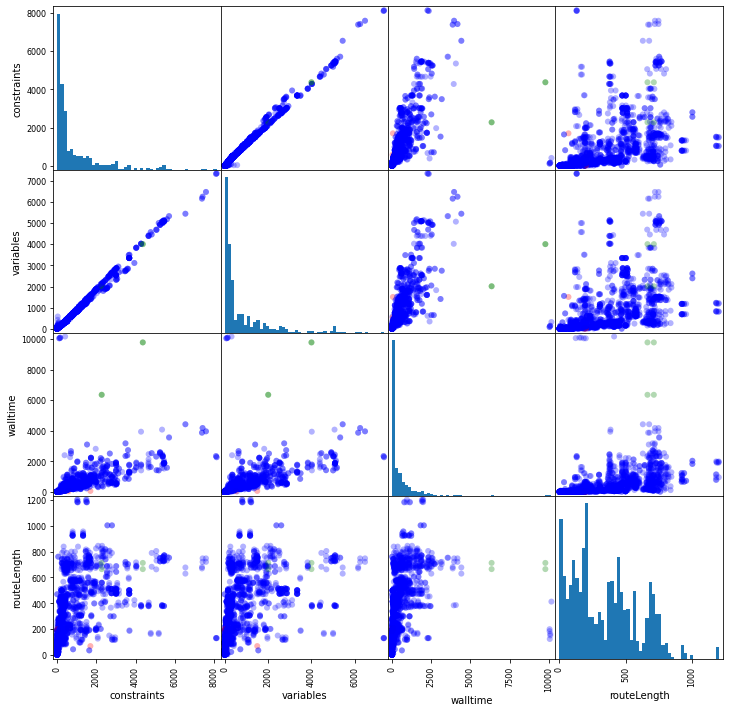

In [149]:
_dict={"Optimal":"b", "Feasible":"g", "Infeasible":"r"}
pd.plotting.scatter_matrix(
    solver_df[["constraints", "variables", "walltime", "routeLength"]].dropna(),
#     c=solver_df.dropna()["vehicle_variant_id"],
    c=solver_df.dropna()["solutionType"].apply(lambda x: _dict[x]),
    figsize=(12, 12),
    marker='o',
    hist_kwds={'bins': 50},
    alpha=.3
);
print("Correlation Matrix")
solver_df[["constraints", "variables", "walltime", "routeLength"]].dropna().corr()

The figure above shows a pair plot of selected optimization parameters together with its correlation matrix. In these pair plots, all variables are plotted against each other in order to visually estimate if there is correlations among the parameters. The diagonal plots are histograms of the variables. The data point colors represent the type of solution, so blue points show optimal solutions, green are feasible solutions, whereas the red points are data from routes that had no solution (infeasible).

As shown in the figure above, we can see that indeed some correlation can be observed. There is, for instance, a strong correlation between the number of variables and the number of constrains, which is expected. From the correlation matrix above we see that the correlation coefficient is almost 1, which means that the correlation is very strong. 

Judging at the walltime,  which is the time it took for the optimization process to find a route solution, we see that this is positively correlated with the amount of constraints and therefore with the variables. The correlation coefficient is about 0.6 for both cases which is also very strong. The walltime correlation with the route length is rather strong, with a coefficient of about 0.4. Therefore, for the walltime we can conclude tha the more constrains/variables the longer it takes to solve. In the same way, the longer the route length is, the longer it takes the solver to find a solution. One way to understand this is that, the longer the route, the more charging stations are considered for the route problem. Also, the more stations we have, the more variables and constrains we have to define. Since the complexity of the problem increases with the amount of variables and constrains one defines, this will off course increase the solving time.

Just for illustration of the possibility to do a vehicle variant comparison, we have plotted below the route length vs. wall time for selected vehicle variants. Here we can see that for all vehicles the wall time tendency is to increase the larger the route length is.

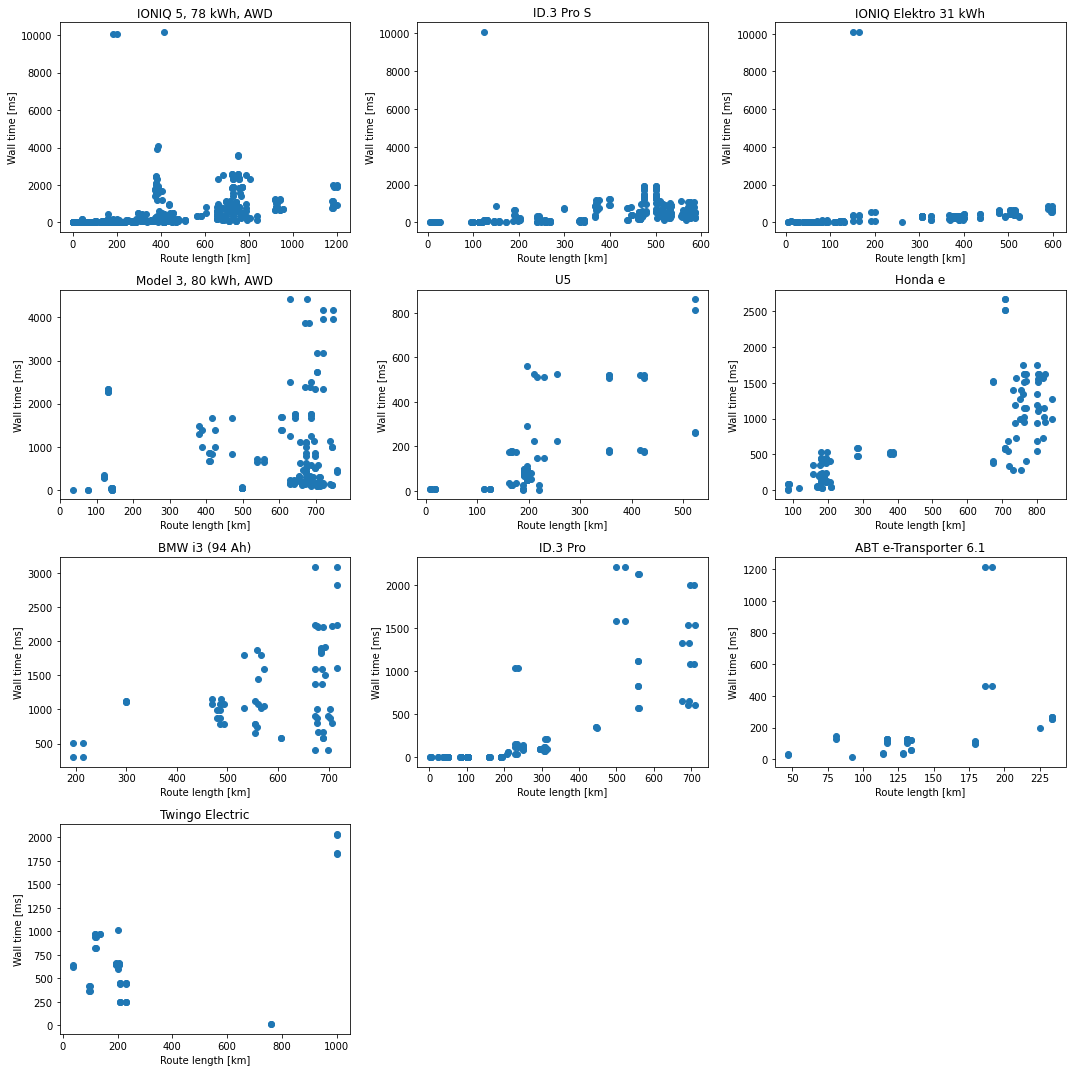

In [156]:
fig = plt.figure(figsize=(15,15))
for i, vv in enumerate(vvids):
    ax = fig.add_subplot(len(vvids)//3+1, 3, i+1) 
    _ = solver_df[solver_df.vehicle_variant_id == vv]
    plt.plot(_.routeLength, _.walltime, 'o')
    plt.title(f"{vehicle_data[vv]['name']}")
    plt.xlabel("Route length [km]")
    plt.ylabel("Wall time [ms]")
plt.tight_layout()

### Runtime Meta Data

The last sort of data we have that can be analyzed is related to diverse runtimes in milliseconds (ms) of functions that are used during the route request. Analysis of these runtimes can help us understand where are possible bottle necks in the code, for instance by looking at those functions that last particularly long during the request. Another possible analysis that one can do, is to monitor the duration of these runtimes as a function of time (timestamps) or api version. In this way, we can see if there is a change in the runtime that might indicate a loss of performance, after release of a new API version, for instance.

Just to start, lets have a look at some statistics of these functions run times.

In [394]:
# add vehicle variant id
metadata_df = metadata_df.set_index("_id").join(request_df[["_id", "vehicle_variant_id"]].set_index("_id")).reset_index()
# add route length
metadata_df = metadata_df.set_index("_id").join(route_df[["_id", "routeLength"]].set_index("_id")).reset_index()
metadata_df.head()

_id               timestamp solverMetadata apiVersion  \
0  62a0780ec4b121e115aaf860 2022-06-08 10:21:02.046             []     0.27.0   
1  62a0781649158b7b66537e80 2022-06-08 10:21:10.056             []     0.27.0   
2  62a07841c72d2c362edccb7c 2022-06-08 10:21:53.174             []     0.27.0   
3  62a07849c4b121e115aaf861 2022-06-08 10:22:01.841             []     0.27.0   
4  62a07854c4b121e115aaf862 2022-06-08 10:22:12.202             []     0.27.0   

   runtimes.RouteService.collect_auto_user_data  \
0                                        400.99   
1                                         55.70   
2                                         58.04   
3                                         25.69   
4                                         27.29   

   runtimes.RouteService.get_route  runtimes.RouteService.get_route_1  \
0                            19.79                              16.89   
1                            15.02                              21.49   
2                            20.33                              18.81   
3                            13.52                              20.55   
4                            11.62                              17.26   

   runtimes.RouteService.filter_opening_times  \
0                                        2.31   
1                                        2.29   
2                                        2.30   
3                                        2.10   
4                                        2.07   

   runtimes.RouteService.filter_opening_times_1  \
0                                          2.28   
1                                          2.77   
2                                          2.16   
3                                          2.26   
4                                          2.02   

   runtimes.RouteService.get_max_range  ...  \
0                                12.52  ...   
1                                 3.63  ...   
2                                 3.42  ...   
3                                 3.04  ...   
4                                 3.07  ...   

   runtimes.DatabaseHelper.query_charge_curves_t_dep_1  \
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

   runtimes.RouteService.group_stations_cluster2  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   runtimes.RouteService.group_stations_cluster2_1  consumptionModelVersion  \
0                                              NaN                      NaN   
1                                              NaN                      NaN   
2                                              NaN                      NaN   
3                                              NaN                      NaN   
4                                              NaN                      NaN   

   battTempModelVersion  consumptionUserModelVersion  \
0                   NaN                          NaN   
1                   NaN                          NaN   
2                   NaN                          NaN   
3                   NaN                          NaN   
4                   NaN                          NaN   

   runtimes.RouteService.create_arcs_ml  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   runtimes.RouteService.create_arcs_ml_1  vehicle_variant_id  routeLength  
0                                     NaN               378.0          NaN  
1                  

In [396]:
# join data from all optimized routes
cols = set(col.split("_1")[0] for col in metadata_df.columns)
metadata_df_joined = metadata_df[cols].copy()

for col in cols:
    try:
        dff = metadata_df.copy().drop(columns=col)
        dff = dff.rename(columns={f"{col}_1": col})
        dff = dff[cols]
        metadata_df_joined = pd.concat([metadata_df_joined, dff])
    except KeyError:
        pass
    
metadata_df_joined = metadata_df_joined.sort_values("timestamp")

In [397]:
metadata_df_stats = metadata_df_joined.describe().T.sort_values("mean", ascending=True)

metadata_df_stats.index = [s.split(".")[-1] for s in metadata_df_stats.index]
metadata_df_stats

count         mean          std    min     25%  \
check_plausibility         26948.0     0.284851     0.178038   0.08    0.19   
filter_arcs                26947.0     4.854974    34.429779   0.02    0.21   
get_max_range              27170.0     6.534696    10.008745   1.59    4.66   
query_dummy_charge_curve    4116.0     7.044337    16.076680   1.31    1.64   
filter_opening_times       27170.0     7.826248     7.721778   0.59    3.48   
get_station_temps           2024.0    15.292925     7.580741   4.29   12.94   
group_stations_cluster1    27013.0    20.297671    11.459337   5.67   13.90   
query_vehicle_temps        23012.0    21.373059    79.192539   1.03    1.71   
get_route                  27170.0    39.636636    34.238354   8.89   21.64   
create_nodes               27170.0    39.937603    25.400332   1.78   13.05   
get_elevations             26947.0    41.051412    26.019391  14.97   23.54   
query_vehicle_variant       8294.0    44.484058    79.339976   6.31    9.34   
group_stations_cluster2    20455.0    50.896588    27.882830   9.14   29.73   
create_arcs                26947.0    52.855620    59.994891   2.55   10.88   
get_final_route            24808.0    60.958813    56.805709   6.29   25.81   
collect_auto_user_data     27346.0    65.765374   142.022185  17.06   23.89   
query_charge_curves_t_dep  22206.0    68.904356    86.456307   4.43   26.80   
create_arcs_ml                44.0   100.395000     4.519666  99.42   99.42   
get_geo_distance           24808.0   137.685242   108.069965   3.35   58.44   
query_route_stations       27170.0   181.458448   203.340036  20.65   52.52   
calc_consumption_profile   24506.0   261.928921   177.448030  25.35  127.68   
solve_route_problem        27632.0   276.557335   574.778436   0.00    8.98   
routeLength                24530.0   338.439910   244.525736   1.10  130.00   
vehicle_variant_id         27412.0   418.281701    70.995327  -1.00  391.00   
get_time_distance_matrix   26285.0  1823.774015  1619.656496  17.92  222.49   
calculate_route_data       26949.0  2466.128850  2028.925712  85.97  531.56   

                               50%        75%       max  
check_plausibility            0.24     0.3500      6.09  
filter_arcs                   0.61     2.5400    622.18  
get_max_range                 4.88     5.2100    461.76  
query_dummy_charge_curve      1.83     2.4500    154.99  
filter_opening_times          5.02     9.7300     56.48  
get_station_temps            15.83    17.5600     50.13  
group_stations_cluster1      16.48    22.6600     91.01  
query_vehicle_temps           1.78     1.8500    826.72  
get_route                    29.15    43.3400    459.74  
create_nodes                 40.50    65.5200     91.57  
get_elevations               36.82    51.1900   1402.71  
query_vehicle_variant        11.93    35.3400    530.44  
group_stations_cluster2      44.99    62.7400    164.28  
create_arcs                  31.96    68.1400    349.25  
get_final_route              40.83    78.0775    415.62  
collect_auto_user_data       25.19    39.4200   1056.66  
query_charge_curves_t_dep    45.45    85.4400   2130.20  
create_arcs_ml               99.42    99.4200    120.87  
get_geo_distance            107.66   188.9500    547.49  
query_route_stations         96.16   224.7500   1969.95  
calc_consumption_profile    218.46   343.7800    873.31  
solve_route_problem          82.10   309.1800  10169.77  
routeLength                 306.00   500.0000   1201.00  
vehicle_variant_id          402.00   438.0000    618.00  
get_time_distance_matrix   1335.62  3467.8200   6167.75  
calculate_route_data       1838.79  4213.5200  13127.41

The table above shows basic runtime statistics for the function used during the route request. For a better appreciation of these values lets have look at some figures. For instance, in the figure below we see the mean runtime values for all the functions. This plot allows us to identify which are those function that take longer to run. For example, we see that the function *get_time_distance_matrix* has the largest mean runtime value of about 1.8 ms. The next second most lengthy function is *calc_consumption_profile* with about 200 ms. This function is called once the final route is optimized and calculates the consumption profiles (SoC vs. km) for all the route legs of the final route. The third most slower function is *solve_route_problem* takes in average also about 200 ms. This function is the one in which the route optimization is performed.

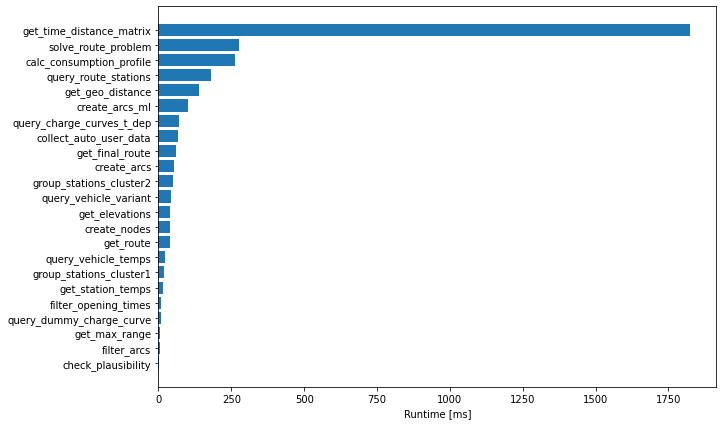

In [410]:
# metadata_df_joined.describe().loc["mean"].plot(kind="barh", figsize=(10,10))
cols_plot = set(metadata_df_stats.index).difference(("calculate_route_data", "routeLength", "vehicle_variant_id"))
_ = metadata_df_stats.loc[cols_plot].sort_values("mean", ascending=True)
plt.figure(figsize=(10,7))
plt.barh(_.index, _["mean"])
plt.xlabel("Runtime [ms]");

The figure below is an example of a time series analysis of one of the functions run time. For this example we have chosen the *collect_auto_user_data* function that performs queries to our mongoDB and postgreSQL databases in order to get current vehicle battery temperatures, users tariff information, so as vehicle information.
Together with the data, we have plotted the 1000 period moving average (orange line). This moving average computes the average value of the runtime for the last 1000 requests. Since this function basically performs I/O processes from request to databases, if the current reading of the runtime deviates strongly from the orange line, it might indicate that the databases have some latency problems, since the requests are taking longer than expected.

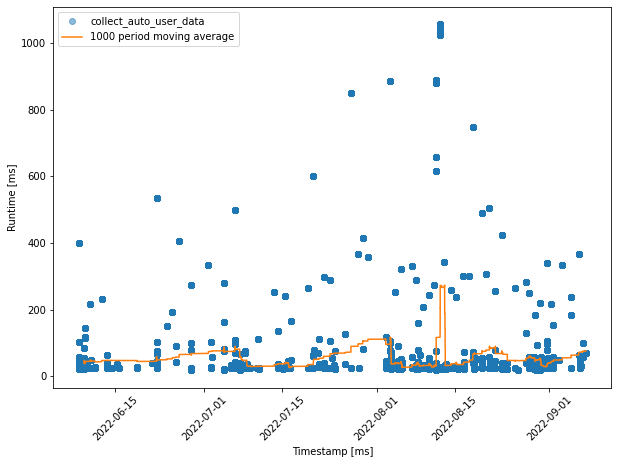

In [388]:
my_col = "runtimes.RouteService.collect_auto_user_data"
dff = metadata_df_joined[["timestamp", my_col]].dropna(subset=[my_col])

plt.figure(figsize=(10,7))
plt.plot(dff.timestamp, dff[my_col], "o", alpha=0.5, label="collect_auto_user_data")
plt.plot(dff.timestamp, dff[my_col].rolling(1000).mean(), "-", label="1000 period moving average")
plt.ylabel("Runtime [ms]")
plt.xlabel("Timestamp [ms]")
plt.legend()
plt.xticks(rotation=45);

Let us now try to evaluate some dependency of these runtimes with the route length. Why is the route length so important? Because as we have seen so far, the longer the route the more complex this tents to be. Some obvious reasons are the amount of charge stations that one considers for such long trips, which implies more arcs and nodes to be defined for the route modeling.

The figures below show the runtimes of the *get_time_distance_matrix* and *create_arcs* functions for different vehicle variants as a function of route length. The blue lines show a linear regression fit with the idea to clearly show the tendency and correlation between these parameters. As observed from the plots there is a clear tendency for the runtimes to increase the longer the routes are.

get_time_distance_matrix


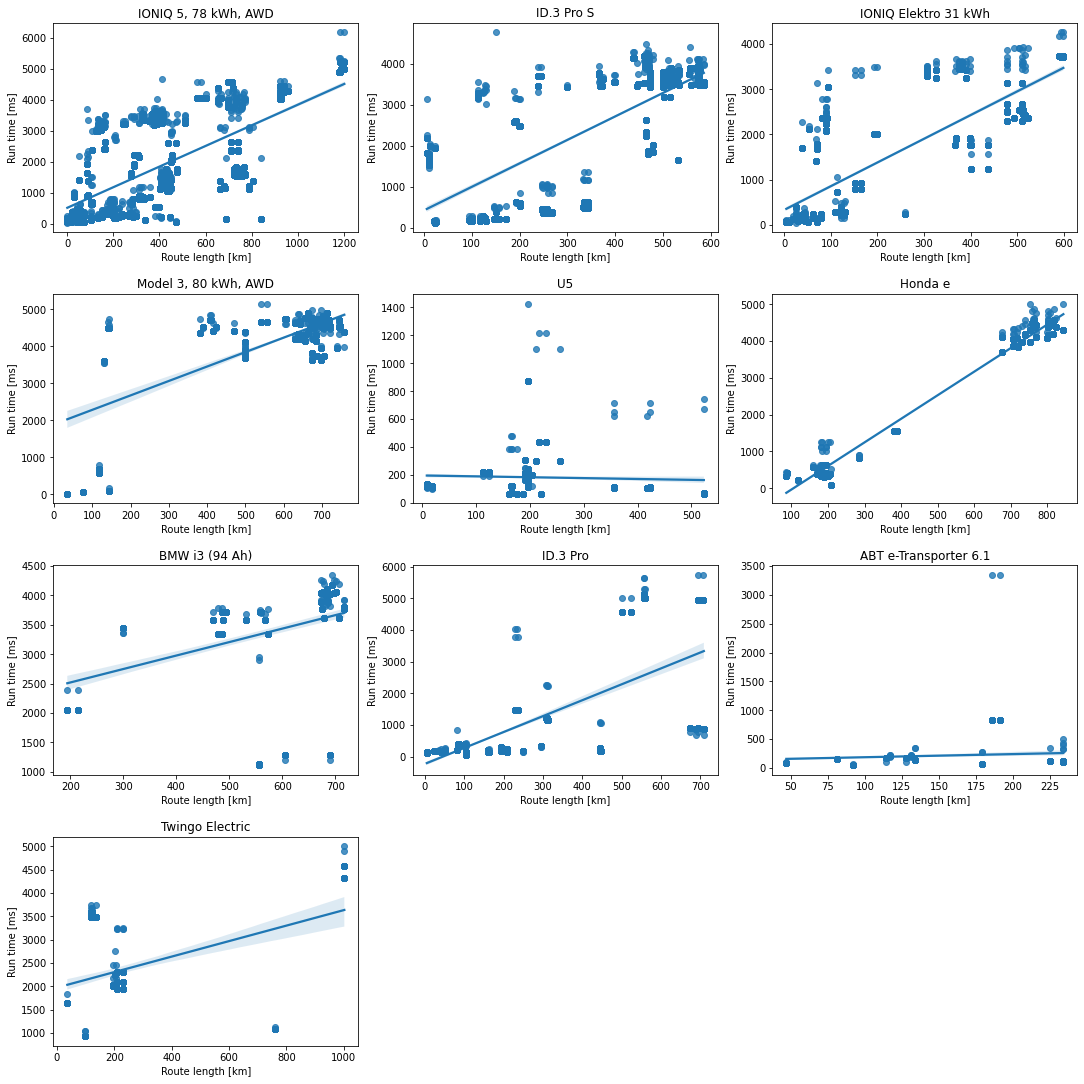

In [451]:
import seaborn as sn
print("get_time_distance_matrix")
fig = plt.figure(figsize=(15,15))
for i, vv in enumerate(vvids):
    ax = fig.add_subplot(len(vvids)//3+1, 3, i+1) 
    _ = metadata_df_joined[metadata_df_joined.vehicle_variant_id == vv]
    sn.regplot(x=_.routeLength, y=_["runtimes.RouteService.get_time_distance_matrix"])
    plt.title(f"{vehicle_data[vv]['name']}")
    plt.xlabel("Route length [km]")
    plt.ylabel("Run time [ms]")
plt.tight_layout(.5,1.5)


create_arcs


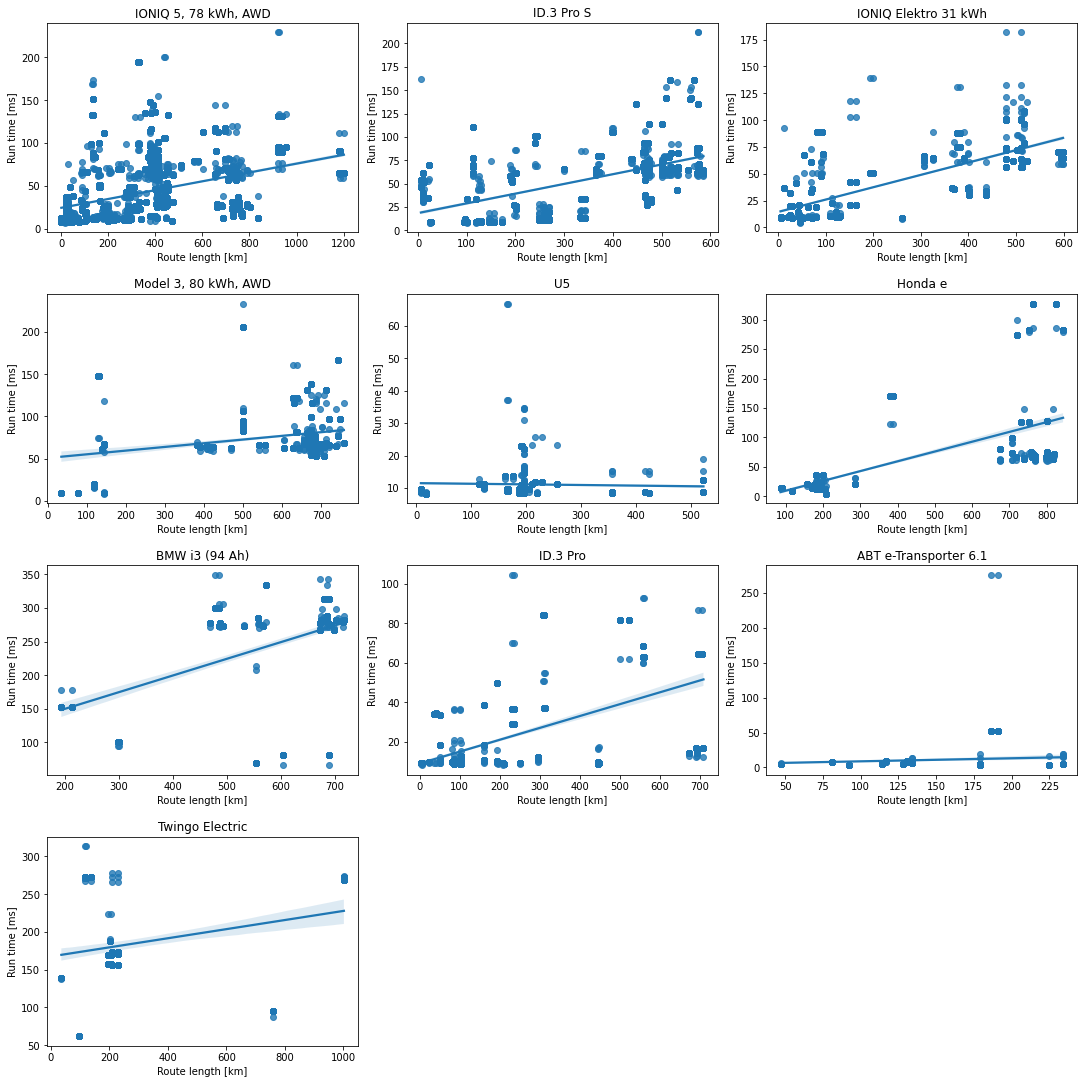

In [450]:
print("create_arcs")
fig = plt.figure(figsize=(15,15))
for i, vv in enumerate(vvids):
    ax = fig.add_subplot(len(vvids)//3+1, 3, i+1) 
    _ = metadata_df_joined[metadata_df_joined.vehicle_variant_id == vv]
    sn.regplot(x=_.routeLength, y=_["runtimes.RouteService.create_arcs"])
    plt.title(f"{vehicle_data[vv]['name']}")
    plt.xlabel("Route length [km]")
    plt.ylabel("Run time [ms]")
plt.tight_layout(.5,1.5)


Also, the *solve_route_problem* function, as shown below, has a tendency to increase the longer the route is, as already discussed.

solve_route_problem


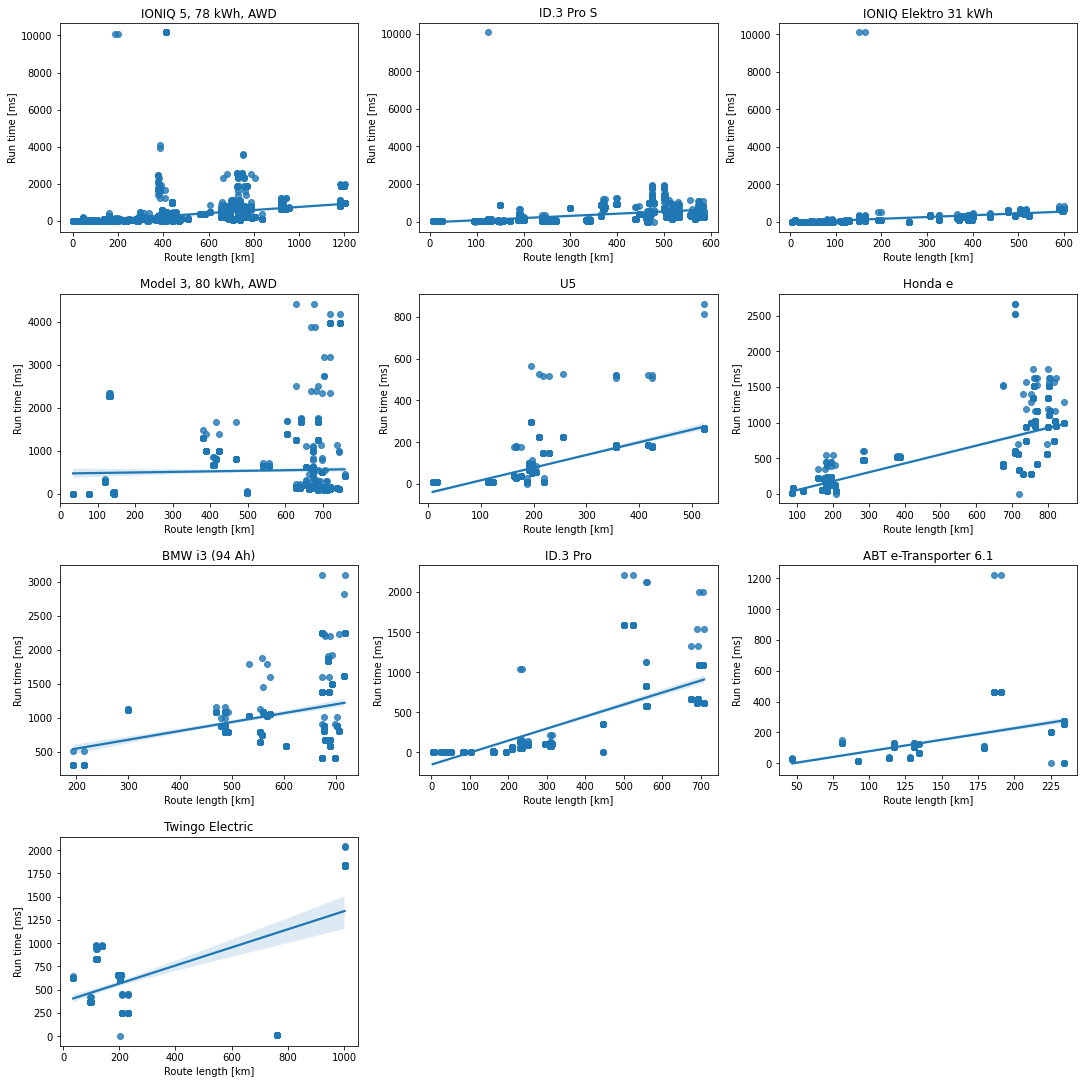

In [472]:
print("solve_route_problem")
fig = plt.figure(figsize=(15,15))
for i, vv in enumerate(vvids):
    ax = fig.add_subplot(len(vvids)//3+1, 3, i+1) 
    _ = metadata_df_joined[metadata_df_joined.vehicle_variant_id == vv].reset_index()
    sn.regplot(x=_.routeLength, y=_["runtimes.RouteService.solve_route_problem"])
    plt.title(f"{vehicle_data[vv]['name']}")
    plt.xlabel("Route length [km]")
    plt.ylabel("Run time [ms]")
plt.tight_layout(.5,1.5)


## Summary

To summarize, we have in this notebook explore possible visualizations of various data that comes from making requests to the route-calculation service. We have seen that in principle there are four sources of data that can be independently considered. For all these data sources we have visualized some of their properties and  statistics. We have for example extracted basic descriptive statistics about parameter values for requests, responses and other metadata. For some of the data, we have also found some correlations that can help us to understand, for example the run times of some functions dependent on route lengths and number of parameters, which determine the complexity of the route request.

Regarding the efficiency of the route-calculation we have analyze various aspects like the amount of errors in the requests and how these can help us find potential bugs in the code. We have also seen that by monitoring the runtimes of some of the functions, specially those related to database I/O requests, can help us understand if there are latency problems.

We have gone a bit further and we have tried to identify a parameter that let us judge the quality of a route. The constant monitoring of such parameter would let us see if changes in the optimization process or code enhances or diminishes the route quality, for instance, after a new release has been deployed.